# 02 - Preparación y Limpieza de Datos

**Proyecto:** Forecast Promtur - Tráfico Orgánico  
**Objetivo:** Transformar y preparar los datos para el análisis de forecasting

---

## Contenido:
1. Carga de datos
2. Transformación de nombres de columnas (snake_case)
3. Cálculo de métricas derivadas
4. Filtrado de canales (opcional)
5. Validación de dataset limpio
6. Guardado de dataset procesado

## 1. Configuración inicial y librerías

In [130]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Ignorar warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Carga de datos

In [131]:
# Definir rutas del proyecto
DATA_RAW = Path('../data/raw')
DATA_PROCESSED = Path('../data/processed')
RESULTS_FIGURES = Path('../results/figures')

# Crear carpetas si no existen
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Cargar dataset
csv_file = DATA_RAW / 'ga4_promtur_organic_2025.csv'

if csv_file.exists():
    df = pd.read_csv(csv_file)
    print(f"✅ Dataset cargado exitosamente")
    print(f"📊 Dimensiones originales: {df.shape[0]} filas x {df.shape[1]} columnas")
else:
    print(f"❌ Error: No se encontró el archivo {csv_file}")
    print(f"📁 Asegúrate de colocar el CSV en: {DATA_RAW}")

✅ Dataset cargado exitosamente
📊 Dimensiones originales: 82 filas x 7 columnas


In [132]:
# Mostrar primeras filas del dataset original
print("📋 Dataset original (primeras 5 filas):\n")
df.head()

📋 Dataset original (primeras 5 filas):



,Year,Month number,Session Default Channel Group Custom (Recovery),Sessions - GA4,Bounces,Total session duration - GA4,Views - GA4
0,2025,1,AI Traffic,135,7,20650,199
1,2025,1,Organic Search,100968,7292,22689260,191522
2,2025,1,Referral,6109,1049,1532485,13551
3,2025,1,Organic Social,858,84,99785,1408
4,2025,1,Organic Video,47,2,14287,136


## 3. Transformación de nombres de columnas a snake_case

Convertiremos los nombres originales de GA4 a formato snake_case para mantener consistencia.

In [133]:
# ===================================================================
# MAPEO DE COLUMNAS: Original → snake_case
# ===================================================================

column_mapping = {
    'Year': 'year',
    'Month number': 'month',
    'Session Default Channel Group Custom (Recovery)': 'channel',
    'Sessions - GA4': 'sessions',
    'Bounces': 'bounces',
    'Total session duration - GA4': 'total_session_duration',
    'Views - GA4': 'views'
}

# Aplicar renombrado
df_clean = df.rename(columns=column_mapping)

print("✅ Columnas renombradas a snake_case\n")
print("📝 Mapeo de columnas:")
for original, nuevo in column_mapping.items():
    print(f"   '{original}' → '{nuevo}'")

✅ Columnas renombradas a snake_case

📝 Mapeo de columnas:
   'Year' → 'year'
   'Month number' → 'month'
   'Session Default Channel Group Custom (Recovery)' → 'channel'
   'Sessions - GA4' → 'sessions'
   'Bounces' → 'bounces'
   'Total session duration - GA4' → 'total_session_duration'
   'Views - GA4' → 'views'


In [134]:
# Verificar nuevos nombres de columnas
print("\n📋 Columnas del dataset limpio:")
for i, col in enumerate(df_clean.columns, 1):
    print(f"{i}. {col}")


📋 Columnas del dataset limpio:
1. year
2. month
3. channel
4. sessions
5. bounces
6. total_session_duration
7. views


In [135]:
# Mostrar dataset con nuevos nombres
print("\n📊 Dataset con nombres en snake_case (primeras 5 filas):\n")
df_clean.head()


📊 Dataset con nombres en snake_case (primeras 5 filas):



,year,month,channel,sessions,bounces,total_session_duration,views
0,2025,1,AI Traffic,135,7,20650,199
1,2025,1,Organic Search,100968,7292,22689260,191522
2,2025,1,Referral,6109,1049,1532485,13551
3,2025,1,Organic Social,858,84,99785,1408
4,2025,1,Organic Video,47,2,14287,136


## 4. Función auxiliar para formateo de duración

Esta función convierte segundos a formato HH:MM:SS para visualización. **No se guardará en el CSV**, solo se usa para exploración.

In [136]:
def segundos_a_hhmm_ss(segundos):
    """
    Convierte segundos a formato HH:MM:SS
    
    Args:
        segundos (float): Duración en segundos
    
    Returns:
        str: Duración en formato HH:MM:SS
    """
    if pd.isna(segundos):
        return "00:00:00"
    
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segs = int(segundos % 60)
    
    return f"{horas:02d}:{minutos:02d}:{segs:02d}"

# Prueba de la función
print("✅ Función de formateo creada")
print("\n📝 Ejemplos de formateo:")
print(f"   155 segundos → {segundos_a_hhmm_ss(155)}")
print(f"   3665 segundos → {segundos_a_hhmm_ss(3665)}")
print(f"   7385 segundos → {segundos_a_hhmm_ss(7385)}")

✅ Función de formateo creada

📝 Ejemplos de formateo:
   155 segundos → 00:02:35
   3665 segundos → 01:01:05
   7385 segundos → 02:03:05


## 5. Cálculo de métricas derivadas

Calcularemos las siguientes métricas:
- **bounce_rate**: Porcentaje de rebotes sobre sesiones
- **views_per_session**: Promedio de vistas por sesión
- **avg_session_duration**: Duración promedio por sesión (en segundos)

In [137]:
# Calcular métricas derivadas
print("🔢 Calculando métricas derivadas...\n")

# 1. Bounce Rate (porcentaje)
df_clean['bounce_rate'] = (df_clean['bounces'] / df_clean['sessions']) * 100

# 2. Vistas por sesión
df_clean['views_per_session'] = df_clean['views'] / df_clean['sessions']

# 3. Duración promedio por sesión (segundos)
df_clean['avg_session_duration'] = df_clean['total_session_duration'] / df_clean['sessions']

print("✅ Métricas derivadas calculadas:")
print("   - bounce_rate (%)")
print("   - views_per_session")
print("   - avg_session_duration (segundos)")

🔢 Calculando métricas derivadas...

✅ Métricas derivadas calculadas:
   - bounce_rate (%)
   - views_per_session
   - avg_session_duration (segundos)


In [138]:
# Crear columna temporal con duración formateada SOLO para visualización
df_clean['duration_formatted'] = df_clean['avg_session_duration'].apply(segundos_a_hhmm_ss)

print("\n📊 Muestra de métricas derivadas (con duración formateada):\n")
display(df_clean[['year', 'month', 'channel', 'sessions', 'bounce_rate', 
                   'views_per_session', 'avg_session_duration', 'duration_formatted']].head(10))


📊 Muestra de métricas derivadas (con duración formateada):



,year,month,channel,sessions,bounce_rate,views_per_session,avg_session_duration,duration_formatted
0,2025,1,AI Traffic,135,5.19,1.47,152.96,00:02:32
1,2025,1,Organic Search,100968,7.22,1.90,224.72,00:03:44
2,2025,1,Referral,6109,17.17,2.22,250.86,00:04:10
3,2025,1,Organic Social,858,9.79,1.64,116.30,00:01:56
4,2025,1,Organic Video,47,4.26,2.89,303.98,00:05:03
5,2025,1,Direct,49275,2.71,1.95,149.88,00:02:29
6,2025,2,Direct,12724,2.92,1.76,238.69,00:03:58
7,2025,2,Email,2,50.00,7.00,492.00,00:08:12
8,2025,2,Organic Video,42,2.38,1.19,250.67,00:04:10
9,2025,2,Organic Social,706,2.41,2.42,228.68,00:03:48


In [139]:
# Estadísticas de métricas derivadas
print("\n📈 Estadísticas de métricas derivadas:\n")
metricas_stats = df_clean[['bounce_rate', 'views_per_session', 'avg_session_duration']].describe()
display(metricas_stats)

# Mostrar rangos de duración en formato legible
print("\n⏱️ Rango de duración promedio por sesión:")
print(f"   - Mínimo: {segundos_a_hhmm_ss(df_clean['avg_session_duration'].min())} ({df_clean['avg_session_duration'].min():.2f} seg)")
print(f"   - Promedio: {segundos_a_hhmm_ss(df_clean['avg_session_duration'].mean())} ({df_clean['avg_session_duration'].mean():.2f} seg)")
print(f"   - Máximo: {segundos_a_hhmm_ss(df_clean['avg_session_duration'].max())} ({df_clean['avg_session_duration'].max():.2f} seg)")


📈 Estadísticas de métricas derivadas:



,bounce_rate,views_per_session,avg_session_duration
count,82.00,82.00,82.00
mean,28.88,1.68,370.24
std,22.56,0.80,1542.24
min,0.00,0.17,0.00
25%,12.50,1.21,102.91
50%,23.54,1.59,183.56
75%,40.26,1.84,244.97
max,100.00,7.00,14104.17



⏱️ Rango de duración promedio por sesión:
   - Mínimo: 00:00:00 (0.00 seg)
   - Promedio: 00:06:10 (370.24 seg)
   - Máximo: 03:55:04 (14104.17 seg)


## 6. Análisis por canal con formato legible

In [140]:
# Resumen de métricas por canal con duración formateada
print("📊 Resumen de métricas promedio por canal:\n")

resumen_canales = df_clean.groupby('channel').agg({
    'sessions': 'sum',
    'bounce_rate': 'mean',
    'views_per_session': 'mean',
    'avg_session_duration': 'mean'
}).round(2)

# Agregar columna con duración formateada
resumen_canales['duration_formatted'] = resumen_canales['avg_session_duration'].apply(segundos_a_hhmm_ss)

# Renombrar columnas para mejor visualización
resumen_canales.columns = ['Sesiones Totales', 'Bounce Rate (%)', 'Vistas/Sesión', 
                            'Duración Avg (seg)', 'Duración (HH:MM:SS)']

display(resumen_canales.sort_values('Sesiones Totales', ascending=False))

📊 Resumen de métricas promedio por canal:



,Sesiones Totales,Bounce Rate (%),Vistas/Sesión,Duración Avg (seg),Duración (HH:MM:SS)
channel,,,,,
Organic Search,828455,16.46,1.79,223.71,00:03:43
Direct,816678,36.19,1.26,115.20,00:01:55
Referral,41339,20.07,2.39,336.01,00:05:36
Organic Social,23690,32.85,1.50,111.85,00:01:51
AI Traffic,2728,19.27,1.52,235.48,00:03:55
Email,796,46.45,1.74,148.63,00:02:28
Organic Video,354,19.79,1.81,237.18,00:03:57
QR Code,51,48.02,2.10,457.34,00:07:37
Organic Shopping,36,54.17,0.79,3526.22,00:58:46


## 7. Filtrado de canales (OPCIONAL)

Aquí puedes decidir si trabajar con TODOS los canales o solo con algunos específicos.

In [141]:
# Mostrar canales disponibles
print("🎯 Canales disponibles en el dataset:\n")
canales_disponibles = df_clean['channel'].unique()
for i, canal in enumerate(sorted(canales_disponibles), 1):
    sesiones_total = df_clean[df_clean['channel'] == canal]['sessions'].sum()
    print(f"{i}. {canal:30s} → {sesiones_total:>10,.0f} sesiones totales")

🎯 Canales disponibles en el dataset:

1. AI Traffic                     →      2,728 sesiones totales
2. Direct                         →    816,678 sesiones totales
3. Email                          →        796 sesiones totales
4. Organic Search                 →    828,455 sesiones totales
5. Organic Shopping               →         36 sesiones totales
6. Organic Social                 →     23,690 sesiones totales
7. Organic Video                  →        354 sesiones totales
8. QR Code                        →         51 sesiones totales
9. Referral                       →     41,339 sesiones totales


In [142]:
# ===================================================================
# CONFIGURACIÓN: Filtrado de canales
# ===================================================================

# Opción 1: Mantener TODOS los canales
usar_todos_los_canales = False

# Opción 2: Especificar canales a incluir (solo si usar_todos_los_canales = False)
canales_incluir = [
    'Organic Search',
    #'Direct',
    #'Referral',
    #'Organic Social',
    'AI Traffic',
    #'Email'
    #'Organic Video',
    #'QR Code',
    #'Organic Shopping',
    
    # Agrega o quita canales según necesites
]

# Aplicar filtro
if usar_todos_los_canales:
    df_final = df_clean.copy()
    print(f"✅ Usando TODOS los canales ({len(canales_disponibles)} canales)")
    print(f"\nCanales incluidos:")
    for canal in sorted(df_final['channel'].unique()):
        print(f"   - {canal}")
else:
    df_final = df_clean[df_clean['channel'].isin(canales_incluir)].copy()
    canales_excluidos = set(canales_disponibles) - set(canales_incluir)
    
    print(f"✅ Filtrado aplicado: {len(canales_incluir)} canales seleccionados")
    print(f"\nCanales INCLUIDOS:")
    for canal in sorted(canales_incluir):
        print(f"   ✓ {canal}")
    
    if canales_excluidos:
        print(f"\nCanales EXCLUIDOS:")
        for canal in sorted(canales_excluidos):
            print(f"   ✗ {canal}")

print(f"\n📊 Dimensiones después del filtrado: {df_final.shape[0]} filas x {df_final.shape[1]} columnas")

✅ Filtrado aplicado: 2 canales seleccionados

Canales INCLUIDOS:
   ✓ AI Traffic
   ✓ Organic Search

Canales EXCLUIDOS:
   ✗ Direct
   ✗ Email
   ✗ Organic Shopping
   ✗ Organic Social
   ✗ Organic Video
   ✗ QR Code
   ✗ Referral

📊 Dimensiones después del filtrado: 22 filas x 11 columnas


## 8. Validación del dataset limpio

In [143]:
# Verificar valores faltantes
print("🔍 Verificación de valores faltantes:\n")
missing = df_final.isnull().sum()
if missing.sum() > 0:
    print("⚠️ Se encontraron valores faltantes:")
    print(missing[missing > 0])
else:
    print("✅ No hay valores faltantes")

🔍 Verificación de valores faltantes:

✅ No hay valores faltantes


In [144]:
# Verificar valores infinitos o NaN en métricas derivadas
print("\n🔍 Verificación de valores infinitos o inválidos:\n")

metricas = ['bounce_rate', 'views_per_session', 'avg_session_duration']
problemas_encontrados = False

for metrica in metricas:
    inf_count = np.isinf(df_final[metrica]).sum()
    nan_count = df_final[metrica].isna().sum()
    
    if inf_count > 0 or nan_count > 0:
        print(f"⚠️ {metrica}:")
        if inf_count > 0:
            print(f"   - Valores infinitos: {inf_count}")
        if nan_count > 0:
            print(f"   - Valores NaN: {nan_count}")
        problemas_encontrados = True

if not problemas_encontrados:
    print("✅ No se encontraron valores infinitos o inválidos")


🔍 Verificación de valores infinitos o inválidos:

✅ No se encontraron valores infinitos o inválidos


In [145]:
# Información del dataset final
print("\nℹ️ Información del dataset final:\n")
df_final.info()


ℹ️ Información del dataset final:

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 0 to 79
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    22 non-null     int64  
 1   month                   22 non-null     int64  
 2   channel                 22 non-null     object 
 3   sessions                22 non-null     int64  
 4   bounces                 22 non-null     int64  
 5   total_session_duration  22 non-null     int64  
 6   views                   22 non-null     int64  
 7   bounce_rate             22 non-null     float64
 8   views_per_session       22 non-null     float64
 9   avg_session_duration    22 non-null     float64
 10  duration_formatted      22 non-null     object 
dtypes: float64(3), int64(6), object(2)
memory usage: 2.1+ KB


In [146]:
# Resumen de estructura del dataset final
print("="*70)
print("📊 RESUMEN DEL DATASET PROCESADO")
print("="*70)

print(f"\n1. DIMENSIONES:")
print(f"   - Total de registros: {df_final.shape[0]}")
print(f"   - Total de columnas: {df_final.shape[1]}")

print(f"\n2. COLUMNAS:")
print(f"   - Dimensiones temporales: year, month")
print(f"   - Dimensión de canal: channel")
print(f"   - Métricas base: sessions, bounces, total_session_duration, views")
print(f"   - Métricas derivadas: bounce_rate, views_per_session, avg_session_duration")

print(f"\n3. CANALES:")
print(f"   - Total de canales: {df_final['channel'].nunique()}")
for canal in sorted(df_final['channel'].unique()):
    registros = len(df_final[df_final['channel'] == canal])
    print(f"   - {canal}: {registros} registros")

print(f"\n4. RANGO TEMPORAL:")
print(f"   - Año(s): {sorted(df_final['year'].unique())}")
print(f"   - Meses: {sorted(df_final['month'].unique())}")
print(f"   - Total de meses: {df_final[['year', 'month']].drop_duplicates().shape[0]}")

print("\n" + "="*70)

📊 RESUMEN DEL DATASET PROCESADO

1. DIMENSIONES:
   - Total de registros: 22
   - Total de columnas: 11

2. COLUMNAS:
   - Dimensiones temporales: year, month
   - Dimensión de canal: channel
   - Métricas base: sessions, bounces, total_session_duration, views
   - Métricas derivadas: bounce_rate, views_per_session, avg_session_duration

3. CANALES:
   - Total de canales: 2
   - AI Traffic: 11 registros
   - Organic Search: 11 registros

4. RANGO TEMPORAL:
   - Año(s): [np.int64(2025)]
   - Meses: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
   - Total de meses: 11



## 9. Visualización rápida de métricas derivadas

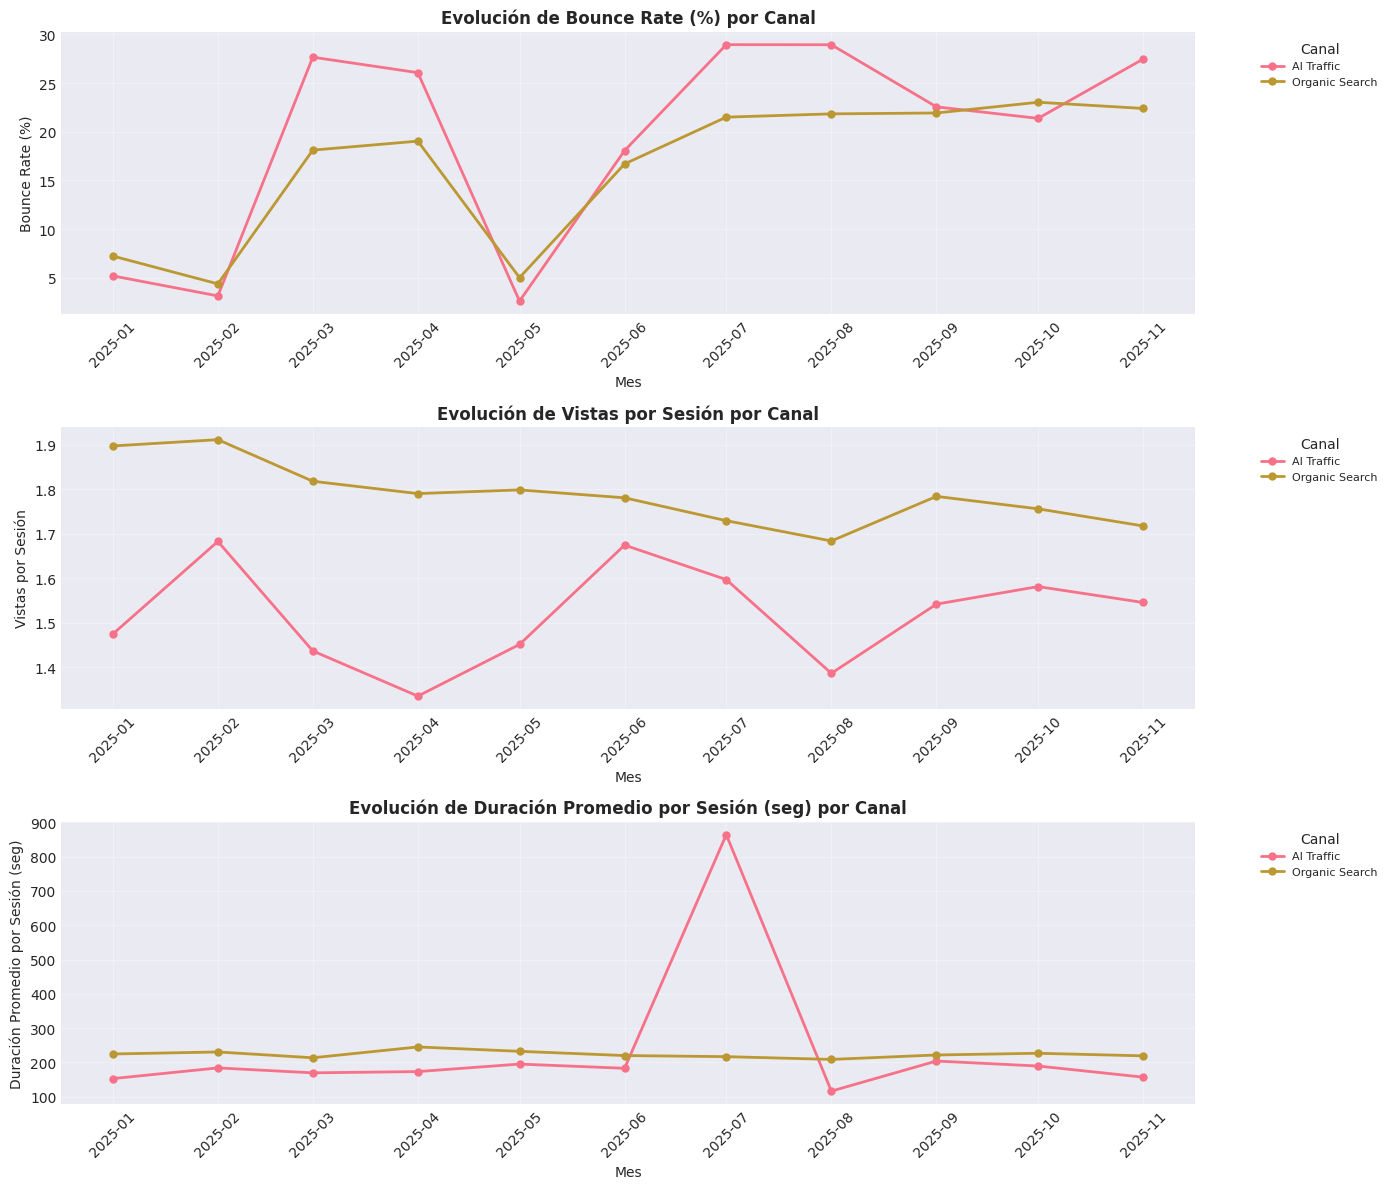

📊 Visualizaciones de métricas derivadas generadas


In [147]:
# Crear columna de fecha para visualizaciones
df_final['fecha'] = pd.to_datetime(
    df_final['year'].astype(str) + '-' + df_final['month'].astype(str) + '-01'
)

# Gráfico: Evolución de métricas derivadas por canal
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

metricas_viz = [
    ('bounce_rate', 'Bounce Rate (%)', axes[0]),
    ('views_per_session', 'Vistas por Sesión', axes[1]),
    ('avg_session_duration', 'Duración Promedio por Sesión (seg)', axes[2])
]

for metrica, titulo, ax in metricas_viz:
    for canal in sorted(df_final['channel'].unique()):
        data_canal = df_final[df_final['channel'] == canal].sort_values('fecha')
        ax.plot(data_canal['fecha'], data_canal[metrica], 
                marker='o', label=canal, linewidth=2, markersize=5)
    
    ax.set_xlabel('Mes', fontsize=10)
    ax.set_ylabel(titulo, fontsize=10)
    ax.set_title(f'Evolución de {titulo} por Canal', fontsize=12, fontweight='bold')
    ax.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("📊 Visualizaciones de métricas derivadas generadas")

## 10. Guardado del dataset procesado

**Nota importante:** Guardaremos `avg_session_duration` en **segundos** (no en formato HH:MM:SS) para que pueda ser usado en modelos de forecasting. La columna `duration_formatted` NO se guardará en el CSV.

In [148]:
# Seleccionar columnas en el orden deseado para el dataset final
# NO incluimos 'duration_formatted' ni 'fecha' (solo para visualización)
columnas_orden = [
    'year',
    'month',
    'channel',
    'sessions',
    'bounces',
    'total_session_duration',
    'views',
    'bounce_rate',
    'views_per_session',
    'avg_session_duration'  # En segundos (número)
]

df_output = df_final[columnas_orden].copy()

# Ordenar por año, mes y canal
df_output = df_output.sort_values(['year', 'month', 'channel']).reset_index(drop=True)

print("📋 Estructura del dataset a guardar:\n")
print("⚠️ Nota: avg_session_duration se guarda en SEGUNDOS (no en formato HH:MM:SS)\n")
df_output.head(10)

📋 Estructura del dataset a guardar:

⚠️ Nota: avg_session_duration se guarda en SEGUNDOS (no en formato HH:MM:SS)



,year,month,channel,sessions,bounces,total_session_duration,views,bounce_rate,views_per_session,avg_session_duration
0,2025,1,AI Traffic,135,7,20650,199,5.19,1.47,152.96
1,2025,1,Organic Search,100968,7292,22689260,191522,7.22,1.90,224.72
2,2025,2,AI Traffic,192,6,35354,323,3.12,1.68,184.14
3,2025,2,Organic Search,86584,3778,19970939,165464,4.36,1.91,230.65
4,2025,3,AI Traffic,188,52,31920,270,27.66,1.44,169.79
5,2025,3,Organic Search,83571,15134,17858226,151896,18.11,1.82,213.69
6,2025,4,AI Traffic,257,67,44575,343,26.07,1.33,173.44
7,2025,4,Organic Search,74501,14179,18271205,133343,19.03,1.79,245.25
8,2025,5,AI Traffic,193,5,37696,280,2.59,1.45,195.32
9,2025,5,Organic Search,67974,3401,15803860,122222,5.00,1.80,232.50


In [149]:
# Guardar dataset procesado
output_file = DATA_PROCESSED / 'dataset_clean.csv'

df_output.to_csv(output_file, index=False)

print(f"✅ Dataset procesado guardado exitosamente")
print(f"📁 Ubicación: {output_file}")
print(f"📊 Dimensiones: {df_output.shape[0]} filas x {df_output.shape[1]} columnas")
print(f"💾 Tamaño del archivo: {output_file.stat().st_size / 1024:.2f} KB")
print(f"\n⚠️ Recordatorio: avg_session_duration está en SEGUNDOS para uso en forecasting")

✅ Dataset procesado guardado exitosamente
📁 Ubicación: ../data/processed/dataset_clean.csv
📊 Dimensiones: 22 filas x 10 columnas
💾 Tamaño del archivo: 2.21 KB

⚠️ Recordatorio: avg_session_duration está en SEGUNDOS para uso en forecasting


In [150]:
# Verificar que el archivo se guardó correctamente
print("\n🔍 Verificación de guardado:\n")

df_verificacion = pd.read_csv(output_file)

if df_verificacion.shape == df_output.shape:
    print("✅ Archivo guardado y verificado correctamente")
    print(f"   - Filas: {df_verificacion.shape[0]}")
    print(f"   - Columnas: {df_verificacion.shape[1]}")
    print(f"\nPrimeras filas del archivo guardado:")
    display(df_verificacion.head())
else:
    print("⚠️ Hay discrepancia entre el dataset original y el guardado")


🔍 Verificación de guardado:

✅ Archivo guardado y verificado correctamente
   - Filas: 22
   - Columnas: 10

Primeras filas del archivo guardado:


,year,month,channel,sessions,bounces,total_session_duration,views,bounce_rate,views_per_session,avg_session_duration
0,2025,1,AI Traffic,135,7,20650,199,5.19,1.47,152.96
1,2025,1,Organic Search,100968,7292,22689260,191522,7.22,1.90,224.72
2,2025,2,AI Traffic,192,6,35354,323,3.12,1.68,184.14
3,2025,2,Organic Search,86584,3778,19970939,165464,4.36,1.91,230.65
4,2025,3,AI Traffic,188,52,31920,270,27.66,1.44,169.79


---

## Resumen de transformaciones aplicadas:

1. ✅ **Renombrado de columnas** a formato snake_case
2. ✅ **Cálculo de métricas derivadas**:
   - `bounce_rate`: % de rebotes
   - `views_per_session`: Promedio de vistas por sesión
   - `avg_session_duration`: Duración promedio en segundos
3. ✅ **Función de formateo** para visualizar duración como HH:MM:SS
4. ✅ **Filtrado de canales** (si se configuró)
5. ✅ **Validación de calidad** de datos
6. ✅ **Guardado** en `data/processed/dataset_clean.csv`

## Nota sobre formato de duración:

- **En el CSV:** `avg_session_duration` se guarda en **segundos** (número)
- **Para visualizar:** Usa la función `segundos_a_hhmm_ss()` cuando necesites formato legible
- **Razón:** Los modelos de forecasting necesitan valores numéricos, no texto formateado

## ✅ Checklist antes de continuar al Notebook 03:

- [ ] Dataset guardado en `data/processed/dataset_clean.csv`
- [ ] Todas las métricas derivadas calculadas correctamente
- [ ] Sin valores faltantes o infinitos
- [ ] Canales seleccionados según necesidad
- [ ] Visualizaciones revisadas
- [ ] Función de formateo probada

## Próximo paso:

**Notebook 03:** Modelos de Forecasting por canal